In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import simpy
import pandas as pd

from scipy.integrate import odeint

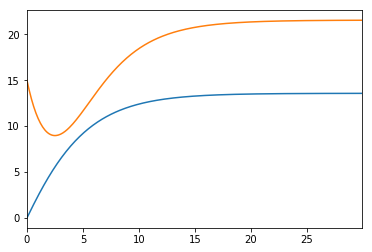

In [97]:
class flow():
    def __init__(self,env,Q=0):
        self.Qout = Q
        self.env = env
        
    def get_Qout(self):
        return self.Qout
        
        
class tank():
    def __init__(self,env,name,C,A,Qin,h):
        self.name = name
        self.C = C
        self.A = A
        self.h = h
        self.data = pd.Series()
        self.Qout = self.C*h**1.5
        self.Qin = Qin
        env.process(self.run())
        
    def get_Qout(self):
        return self.Qout

    def run(self):
        while True:
            self.data.set_value(env.now,self.h)
            f = lambda h,t : (-self.C*h**1.5 + self.Qin())/self.A
            self.Qout = self.C*self.h**1.5
            yield env.timeout(0.1)
            self.h = odeint(f,self.h,[0,.1])[-1][0]

env = simpy.Environment()
Q = flow(env,10)
tank_1 = tank(env,'A',.2,4,Q.get_Qout,0)
tank_2 = tank(env,'B',.1,1,tank_1.get_Qout,15)
env.run(until=30)

tank_1.data.plot()
tank_2.data.plot()


In [67]:
class stream():
    def __init__(self,env,Q=0):
        self.Q = Q
        self.env = env
        self.hist = pd.Series()
      
    def qout(self):
        return self.q
    
    def qin(self,qin):
        self.Q = qin
        self.hist.set_value(env.now,qin)
        
        
    


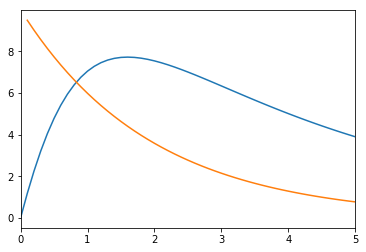

In [75]:
# A draining tank

class PV():
    qin = 0
    qout = 0


class tank():
    def __init__(self,env,C,A,h,fin):
        self.C = C
        self.A = A
        self.h = h
        self.hist = pd.Series()
        env.process(self.run())
        self.qout = 0
        self.qin = fin

    def run(self):
        while True:
            self.hist.set_value(env.now,self.h)
            f = lambda h,t : (-self.C*h**1.5 + self.qin())/self.A
            self.qout = -self.C*self.h**1.5
            yield env.timeout(0.1)
            self.h = odeint(f,self.h,[0,.5])[-1][0]

class flow():
    def __init__(self,env,q,qin):
        self.q = q
        env.process(self.run())
        self.qin = qin
        
    def qout(self):
        return self.q
    
    def run(self):
        while True:
            yield env.timeout(0.1)
            self.q = 0.95*self.q
            self.qin(self.q)

env = simpy.Environment()
s = stream(env)
qflow = flow(env,10,s.qin)
unit_1 = tank(env,.2,4,0,qflow.qout)
env.run(until=5)

unit_1.hist.plot()
PV.qout
s.hist.plot()